In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
from math import sqrt,cos,acos,pi,exp,sin,atan2,log
from numpy import arange,mean,asarray,isnan,isinf
import pickle as pkl
from scipy import stats

import csv
import sys
import pandas as pd
import os

from DavioPlotter import *

finalPred = False
fset = 11 # 0 = open data, 1-7 = fake datasets, 8 = High E far sideband, 9 = Low BDT far sideband, 10 = Full near sideband
cutMode = 0 # 0 = Final Selection, 1 = Kin Cut Sample, 2 = High E, 3 = Low BDT, 4 = 
if fset==8: cutMode = 2
if fset==9: cutMode = 3
    
cutmodedir = {0:'FinalSelection',1:'KinCut',2:'HighE',3:'LowBDT'}[cutMode]

lowEpatch = False#True if fset in [0,5,8,9] else False
vtxCut    = 5#np.inf

C1_POT = 1.558e+20 + 1.129e+17 + 1.869e+19
D2_POT = 1.63e+20 + 2.964e+19 + 1.239e+19
E1_POT = 5.923e+19
F1_POT = 4.3e+19
G1_POT = 1.701e+20 + 2.97e+19 + 1.524e+17


if fset==0: 
    DAT_POT1 = 4.403e19
    DAT_POT2 = 0
    DAT_POT3 = 8.786e+18
elif fset==1: 
    DAT_POT1  = 1.935765e20
    DAT_POT2 = 0
    DAT_POT3  = 2.99974063e20
elif fset==2: 
    DAT_POT1 = 4.0129213616e20
    DAT_POT2 = 0
    DAT_POT3 = 3.85169302616e20
elif fset==3: 
    DAT_POT1 = 4.024614415411e20
    DAT_POT2 = 0
    DAT_POT3 = 3.9685728933181e20
elif fset==4: 
    DAT_POT1 = 3.907905653e20
    DAT_POT2 = 0
    DAT_POT3 = 3.92356759e20
elif fset==5: 
    DAT_POT1 = 7.00587e20
    DAT_POT2 = 0
    DAT_POT3 = 0
elif fset==7: 
    DAT_POT1 = 1.8382999360024655e+20
    DAT_POT2 = 0
    DAT_POT3 = 2.05E+20
elif(fset==8):
    DAT_POT1 = C1_POT
    DAT_POT2 = D2_POT+E1_POT
    DAT_POT3 = F1_POT+G1_POT
elif(fset==9):
    DAT_POT1 = C1_POT
    DAT_POT2 = D2_POT+E1_POT
    DAT_POT3 = G1_POT
elif(fset ==10):
    DAT_POT1 = 1.631e+20#-1.613e+20
    DAT_POT2 = 2.750e+20#-2.687e+20
    DAT_POT3 = 2.291e+20#-2.017e+20
elif(fset ==11):
    DAT_POT1 = 1.69E+20
    DAT_POT2 = 2.73E+20
    DAT_POT3 = 2.44E+20


if finalPred and fset==0:
    DAT_POT1 = C1_POT
    DAT_POT2 = E1_POT+D2_POT
    DAT_POT3 = F1_POT+G1_POT
    
DATA_POT_TOT = DAT_POT1 + DAT_POT2 + DAT_POT3


print(DAT_POT1,DAT_POT2,DAT_POT3)
print(DAT_POT1+DAT_POT2+DAT_POT3)

def poisson_errors(k, CL = 0.6827):
    
    # 1 Sig = 0.6827
    # 2 Sig = 0.9545
    # 3 Sig = 0.9973
    
    a = 1.0 - CL
    low, high = (stats.chi2.ppf(a/2, 2*k) / 2, stats.chi2.ppf(1-a/2, 2*k + 2) / 2)
    low = np.where(k==0,0,low)
    return k - low, high - k


1.69e+20 2.73e+20 2.44e+20
6.86e+20


In [2]:
tag='3March2021_vA_fullLowE_withPi0Sample_newShowerCalib'
#tag='7July2021_vA_fullLowE_withPi0Sample_newShowerCalib_noEnu'

filetaglist = {1:['data','dirt','ext','overlay','overlay_lowE','intrinsics','intrinsics_lowE','ncpi0','ccpi0'],
               2:['data','dirt','ext','overlay','overlay_lowE','intrinsics','intrinsics_lowE'],
               3:['data','dirt','ext','overlay','overlay_lowE','intrinsics','intrinsics_lowE','ncpi0','ccpi0']}

df = {1:{},2:{},3:{}}

psavedir = 'Parquets/'+tag+'/'

for r in [1,2,3]:
    print('\n\n','#'*20,'RUN',r,'#'*20,'\n')

    for filetag in filetaglist[r]:
        df[r][filetag] = pd.DataFrame()
        if not lowEpatch and 'lowE' in filetag: continue
        print('Sample:',filetag)
        if filetag=='data':
            pstring = 'SelectionMode%i_%s_fset%i_run%i.parquet.gzip'%(cutMode,filetag,fset,r)
        else:
            pstring = 'SelectionMode%i_%s_fset%i_run%i.parquet.gzip'%(cutMode,filetag,fset,r)
        try:
            df[r][filetag] = pd.read_parquet(psavedir+pstring)
            print(len(df[r][filetag]))
        except:
            print('No Events')
            pass
        
df[2]['ext'] = df[3]['ext'].copy()
df[1]['dirt'] = df[3]['dirt'].copy()
df[2]['dirt'] = df[3]['dirt'].copy()
if fset in [8,9,10]:
    df1d = (df[1]['data'].copy()).query('run<8000')
    df2d = (df[1]['data'].copy()).query('run>8000 and run<13000')
    df3d = (df[1]['data'].copy()).query('run>13000')
    df[1]['data'] = df1d
    df[2]['data'] = df2d
    df[3]['data'] = df3d



 #################### RUN 1 #################### 

Sample: data
1549
Sample: dirt
No Events
Sample: ext
263
Sample: overlay
5602
Sample: intrinsics
14733
Sample: ncpi0
589
Sample: ccpi0
285


 #################### RUN 2 #################### 

Sample: data
1989
Sample: dirt
No Events
Sample: ext
No Events
Sample: overlay
5784
Sample: intrinsics
11241


 #################### RUN 3 #################### 

Sample: data
1862
Sample: dirt
63
Sample: ext
537
Sample: overlay
3943
Sample: intrinsics
5940
Sample: ncpi0
504
Sample: ccpi0
266


In [3]:
    

varb_names = ['Enu_1e1p','Eta','PT_1e1p','AlphaT_1e1p',
              'SphB_1e1p','PzEnu_1e1p','ChargeNearTrunk',
              'Q0_1e1p','Q3_1e1p','Thetas','Phis','PTRat_1e1p',
              'Proton_ThetaReco','Proton_PhiReco',
              'MinShrFrac','MaxShrFrac',
              'BjXB_1e1p','BjYB_1e1p','Proton_Edep',
              'Electron_Edep',
              'Lepton_ThetaReco','Lepton_PhiReco',
              'OpenAng','Xreco','Yreco','Zreco',
              'sigprob','MPIDY_muon',
              'MPIDY_proton','MPIDY_eminus','shower_fraction',
              'Shower_Consistency',
              'EnuQE_lepton','EnuQE_proton',
              'Proton_TrackLength','Lepton_TrackLength','EnuTrue']

var_labels = [r'$E_\nu^{Range}$ [MeV]',r'$\eta$',r'Event $p_T$ [MeV]',r'$\alpha_T$',
              'QE Consistency',r'$p_z - E_\nu$ [MeV]','Charge Near Trunk',
              r'$Q_0$ [MeV]',r'$Q_3$ [MeV]',r'$\theta_e + \theta_p$',r'$|\phi_e - \phi_p|$',r'Event $p_T/p$',
              r'$\theta_p$',r'$\phi_p$',
              'Minimum Shower Fraction','Maximum Shower Fraction',
              'Bjorken X (Nucleon Rest Frame)','Bjorken Y (Nucleon Rest Frame)',r'$E_p$ [MeV]',
              r'$E_e$ [MeV]',
              r'$\theta_e$',r'$\phi_e$',
              'Opening Angle',r'$X_{reco}$',r'$Y_{reco}$','$Z_{reco}$',
              '1e1p BDT Score','Muon MPID Score (Y plane)',
              'Proton MPID Score (Y plane)','Electron MPID Score (Y plane)','Shower Fraction',
              'Shower Energy Consistency',
              r'$E_\nu^{Q-e}$',r'$E_\nu^{QE-p}$',
              'Proton Track Length [cm]','Lepton Track Length [cm]',r'$E_\nu^{True}$ [MeV]']

ranges = [ (0,1200),(0,0.6),(0,800),(0,np.pi),(0,5000),(-800,300),
           (0,800),(100,700),(0,1400),(0,2*np.pi),(0,2*np.pi),
           (0,1),(0,np.pi),(-np.pi,np.pi),(-1,1),(-1,1),(0,3),
           (0,1),(60,500),(35,1200),(0,np.pi),
           (-np.pi,np.pi),(0,np.pi),(0,256),(-117,117),(0,1036),
           (0.0,1.0),(0,1),(0,1),(0,1),(0,3),(0,5),
           (0,1200),(0,1200),(0,100),(0,200),(0,1200)]

varlabel_dict = {name:label for name,label in zip(varb_names,var_labels)}
range_dict = {name:rnge for name,rnge in zip(varb_names,ranges)}

if cutMode in [0,2]: range_dict['sigprob'] = (0.95,1.0)
    

In [4]:
# HELPER FUNCTIONS
detsystag = '2August2021'
#detsystag = '5Apr2021'

def getSysErrors(nbins,varName,mode,sigcut,rwtnameoverride=None,nsbmode=0):
    try:
        if nsbmode in [1,2,3]: 
            if nsbmode!=3: det_sys_m = np.loadtxt('CovMatrices/DetVar/'+tag+'/14July2021/covMatrix/'+mode+'/BDTcut'+str(sigcut)+'/nsbmode'+str(nsbmode)+'/detsys_'+varName+'_run13_cutMode'+str(cutMode)+'_cov_smooth.csv',delimiter=',')
            if nsbmode==3: det_sys_m = np.loadtxt('CovMatrices/DetVar/'+tag+'/'+detsystag+'/covMatrix/'+mode+'/BDTcut0.95/detsys_'+varName+'_run13_cutMode'+str(cutMode)+'_cov_smooth.csv',delimiter=',')
            elif varName=='Enu_1e1p':
                det_sys_tmp = np.zeros((12,12))
                if nsbmode==1: det_sys_tmp[5:,5:] = det_sys_m
                if nsbmode==2: det_sys_tmp[5:7,5:7] = det_sys_m
                det_sys_m = det_sys_tmp
        else: det_sys_m = np.loadtxt('CovMatrices/DetVar/'+tag+'/'+detsystag+'/covMatrix/'+mode+'/BDTcut'+str(sigcut)+'/detsys_'+varName+'_run13_cutMode'+str(cutMode)+'_cov_smooth.csv',delimiter=',')
    except:
        print('No det sys')
        det_sys_m = np.zeros((nbins,nbins))
            
    try:
        if rwtnameoverride is not None:
            rwt_sys_m = np.loadtxt('CovMatrices/RwghtSys/frac_covar_rewgt_'+rwtnameoverride+'__'+varName+'.txt')
        else:
            if varName=='sigprob': varName='sigprobavg'
            rwt_sys_m = np.loadtxt('CovMatrices/RwghtSys/frac_covar_rewgt_'+cutmodedir+'__'+varName+'.txt')
    except:
        print('No rwt sys')
        rwt_sys_m = np.zeros((nbins,nbins))
    
    if nsbmode==3 and varName=='MPIDY_muon':
        det_sys_tmp = np.zeros((3,3))
        rwt_sys_tmp = np.zeros((3,3))
        det_sys_tmp[:2,:2] = det_sys_m[:2,:2]
        rwt_sys_tmp[:2,:2] = rwt_sys_m[:2,:2]
        det_sys_tmp[1,2] = det_sys_m[1,7]
        det_sys_tmp[0,2] = det_sys_m[0,7]
        det_sys_tmp[2,1] = det_sys_m[7,1]
        det_sys_tmp[2,0] = det_sys_m[7,0]
        det_sys_tmp[2,2] = det_sys_m[7,7]
        rwt_sys_tmp[1,2] = rwt_sys_m[1,7]
        rwt_sys_tmp[0,2] = rwt_sys_m[0,7]
        rwt_sys_tmp[2,1] = rwt_sys_m[7,1]
        rwt_sys_tmp[2,0] = rwt_sys_m[7,0]
        rwt_sys_tmp[2,2] = rwt_sys_m[7,7]
        det_sys_m,rwt_sys_m = det_sys_tmp,rwt_sys_tmp
    
    rwt_sys_m = np.where(np.isnan(rwt_sys_m),0,rwt_sys_m)
    det_sys_m = np.where(np.isnan(det_sys_m),0,det_sys_m)
    return rwt_sys_m,det_sys_m

def getDetSysTot(det_sys_nue,nue,numu):
    det_sys_numu = np.diag(0.04*np.ones(det_sys_nue.shape[0]))
    tot = nue+numu
    return (det_sys_nue * np.outer(nue,nue) + det_sys_numu * np.outer(numu,numu))/np.outer(tot,tot)
    

def MakeBDTcut(idf,sigcut,mode,nBDTs,r2overlay=False,ttc=0.1):
    
    # Conglemerate BDT scores and weights based on strategy 
    
    bdtweight = np.zeros(idf.shape[0])
    sigprobmax = np.zeros(idf.shape[0]) 
    sigprobavg = np.zeros(idf.shape[0])
    sigprobmedian = np.zeros(idf.shape[0])
    sigproblist = np.zeros((idf.shape[0],nBDTs))
    notintrain = np.zeros((idf.shape[0],nBDTs),dtype=bool)
    numnottrain = np.zeros(idf.shape[0])
    for b in range(nBDTs):
        sp = idf['sigprob%i'%b]
        tvw = idf['tvweight%i'%b]
        sigprobmax = np.where(np.logical_and(tvw>0,sp>sigprobmax),sp,sigprobmax) # cut on the maximum non-train score in ensemble
        if mode == 'fracweight': 
            #bdtweight += np.where(sp>sigcut,tvw/float(nBDTs),0)
            bdtweight += np.where((tvw>ttc) & (sp>sigcut),1.0,0.0)
        sigprobavg += np.where(tvw>ttc,sp,0)
        numnottrain += np.where(tvw>ttc,1,0)
        sigproblist[:,b] = sp
        notintrain[:,b] = tvw > ttc
    sigprobavg /= np.where(numnottrain>0,numnottrain,1)
    for i,(tlist,siglist) in enumerate(zip(notintrain,sigproblist)):
        splist = siglist[tlist]
        if splist.size!=0: sigprobmedian[i] = np.median(splist)
        else: sigprobmedian[i] = 0
        
    idf['sigprobavg'] = sigprobavg
    idf['sigprobmedian'] = sigprobmedian
    idf['sigprobmax'] = sigprobmax

    
    if mode == 'avgscore':
        idf['sigprob'] = idf['sigprobavg']
        bdtweight = np.where(sigprobavg>sigcut,1,0)
    elif mode == 'medianscore':
        idf['sigprob'] = idf['sigprobmedian']
        bdtweight = np.where(sigprobmedian>sigcut,1,0)
    elif mode == 'fracweight':
        idf['sigprob'] = idf['sigprobmax']
        bdtweight /= np.where(numnottrain>0,numnottrain,1)
    
    idf['bdtweight'] = bdtweight
    
    # Drop duplicates
    
    idf.sort_values(by=['run','subrun','event','sigprob'],ascending=False,inplace=True)
    if r2overlay:
        idf.drop_duplicates(subset=['run','subrun','event','EnuTrue'],inplace=True)
    else:
        idf.drop_duplicates(subset=['run','subrun','event'],inplace=True)
    
def SaveTextFile(idf,run,filetag,sigcut,mode,tsavedir):
    nBDTs = int(idf['nBDTs'][0])
    MakeBDTcut(idf,sigcut,mode,nBDTs)
    idf.query('sigprob > @sigcut',inplace=True)
    savestr = 'eventlist_%s_run%i.txt'%(filetag,run)
    idf.to_csv(tsavedir+savestr,index=None,sep=' ')
    
    

In [5]:
mu_cutoff = 0.46149198646840239

def chi2_cnp(M,mu):
    c2c=0
    if mu>0:
        if M != 0:
            c2c = (M - mu)**2/(3 / (2 / mu + 1 / M))
        else:
            c2c = mu/2#(M - mu)**2/(3 / (2 / mu + 1 / mu))
    return c2c

def chi2_pois(M,mu):
    c2c=0
    if mu > 0:
        if M != 0:
            c2c = 2*(mu - M + M*np.log(M/mu))
        else:
            c2c = 2*mu
    return c2c

def chi2_pears(M,mu):
    c2c=0
    if mu > 0:
        if M != 0:
            c2c = (M-mu)**2 / mu
        else:
            c2c = 2*mu
    return c2c

def chi2_thresh(M,mu,mode='cnp'):
    c2c=0
    if mu > mu_cutoff and mode=='cnp':
        c2c = chi2_cnp(M,mu)
    elif mu > mu_cutoff and mode=='pearson':
        c2c = chi2_pears(M,mu)
    else:
        c2c = chi2_pois(M,mu)
    return c2c

def cov_pois(M,mu):
    cov=0
    if mu > 0:
        if M != 0:
            cov = (M-mu)**2 / (2*(mu - M + M*np.log(M/mu)))
        else:
            cov = mu/2
    return cov

def cov_cnp(M,mu):
    cov=0
    if mu > 0:
        if M != 0:
            cov = (3. / (2. / mu + 1. / M))
        else:
            cov = mu/2
    return cov

def cov_pears(M,mu):
    cov=0
    if mu > 0:
        cov = mu
    return cov

def cov_thresh(M,mu,mode='cnp'):
    cov=0
    if mu>mu_cutoff and mode=='cnp':
        cov=cov_cnp(M,mu)
    elif mu>mu_cutoff and mode=='pearson':
        cov=cov_pears(M,mu)
    else:
        cov=cov_pois(M,mu)
    return cov


/home/nwkamp/.local/lib/python2.7/site-packages/ipykernel_launcher.py:196: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/nwkamp/.local/lib/python2.7/site-packages/ipykernel_launcher.py:197: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/nwkamp/.local/lib/python2.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in divide
/home/nwkamp/.local/lib/python2.7/site-packages/ipykernel_launcher.py:532: RuntimeWarning: invalid value encountered in divide
/home/nwkamp/.local/lib/python2.7/site-packages/ipykernel_launcher.py:583: Ru

<Figure size 432x288 with 0 Axes>

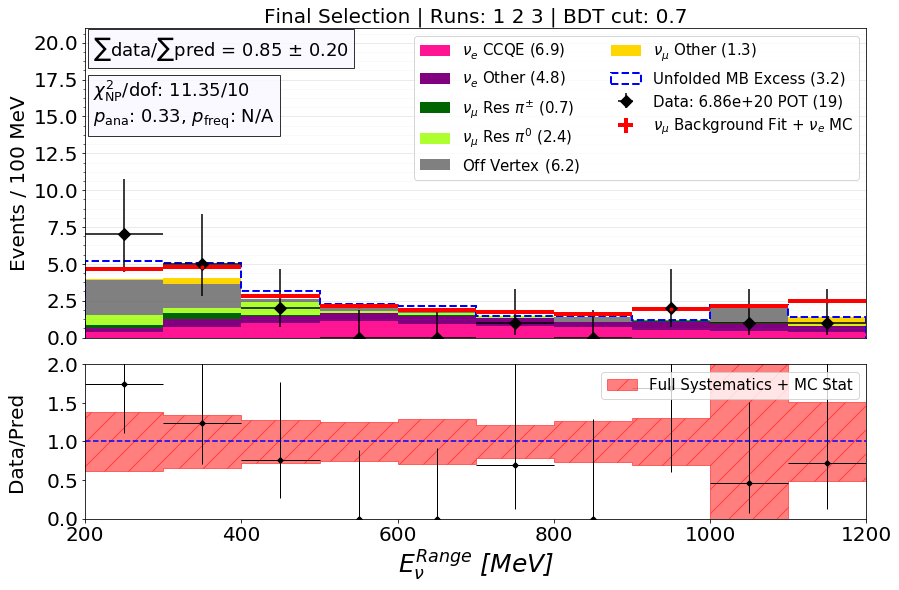

<Figure size 432x288 with 0 Axes>

In [10]:
fudge_bkg = 1.0
fudge_sig = 1.0
fudge_dirt = 0.0

plot_thresh = 0.05

# Near sideband stuff
nsbmode = 3 # 1 = Enu>500, 2 = 500<Enu<700, 3 = 0.7 < BDT < 0.95, 4 = 0.01 < BDT < 0.95
nsbrwtovr = None
if nsbmode in [1,2,3]: 
    nsbrwtovr = 'samp%i'%nsbmode
    freqp = pd.read_csv('FreqPVals/samp%i_total.txt'%nsbmode)
if nsbmode==3:
    range_dict['sigprob'] = (0.7,0.95)
elif nsbmode==4:
    range_dict['sigprob'] = (0.01,0.95)
elif nsbmode in [1,2]:
    range_dict['sigprob'] = (0.95,1.0)


#Binary Settings
verbose = False
sys     = True
plotPurity = False
topplot = False
pi0wplot = False
davioplot = False
makeCutData = False if fset in [8,9,10] else True

#BDT Settings
bdtmode = 'avgscore'
nBDTs = 20
bdtpower = 0
bdtcutRange = [range_dict['sigprob'][0]]


runs_to_plot = [#[1],
                #[2],
                #[3],
                [1,2,3]]

POTdict = {1:{ft:DAT_POT1 for ft in filetaglist[1]},
           2:{ft:DAT_POT2 for ft in filetaglist[2]},
           3:{ft:DAT_POT3 for ft in filetaglist[3]}}

if fset in [8,9,10]: 
    POTdict[1]['data'] = DATA_POT_TOT
    POTdict[2]['data'] = DATA_POT_TOT
    POTdict[3]['data'] = DATA_POT_TOT
    
pvalsa = []
pvalsf = []

cls  = ['deeppink','purple','brown','blue','cyan','darkgreen','greenyellow','gold','gray','fuchsia']


    


for varName in varb_names:


    
    if varName not in ['Enu_1e1p']: continue
    if varName=='EnuTrue' and not finalPred: continue
    
        
    xlab = varlabel_dict[varName]
        
    bins  = 12 if varName in ['Enu_1e1p','EnuQE_proton','EnuQE_lepton','EnuTrue'] else 10
    low   = (range_dict[varName])[0]
    high  = (range_dict[varName])[1]
    if nsbmode==2 and varName!='Enu_1e1p': bins/=2
    binrange = np.linspace(low,high,bins+1)
    if nsbmode==3 and varName=='MPIDY_muon':
        bins=3
        binrange = np.array([0,0.1,0.2,1.0])
    
    
    
    for runs_included in runs_to_plot: # [run 1, run 2 run 3]
        
        pRatDict = {}
        pErrDict = {}
        
        for cut in bdtcutRange:
            
            if cutMode in [0,2] and varName=='sigprob': low = cut

            if fset in range(1,8): plotTitle = 'Fake Dataset '+str(fset)+' / Runs:'
            elif cutMode==0: plotTitle = 'Final Selection | Runs:'
            elif cutMode==1: plotTitle = 'Loose Kinematic Cuts | Runs:'
            elif cutMode==2: plotTitle = 'High Energy Sideband | Runs:'
            elif cutMode==3: plotTitle = 'Low BDT Sideband | Runs:'
            plotFileName = varName
            FullPOT = 0
            POT1 = 0
            POT23 = 0

            vars_arr = []
            weights_arr = []
            labels_arr = []
            leew_arr = []
            Enu_arr = []

            dflist = []
            dfdat = pd.DataFrame()
            dflee = pd.DataFrame()
            dftot = pd.DataFrame()
            
            bkginttype = {}
            onvbkginttype = {}
            offvbkginttype = {}
            
            for r in runs_included:
                plotTitle += ' %i'%r
                plotFileName += '_%i'%r
                FullPOT += POTdict[r]['overlay']
                if r == 1: POT1 += POTdict[r]['overlay']
                elif r in [2,3]: POT23 += POTdict[r]['overlay']

                for filetag in df[r].keys():
                    if df[r][filetag].empty: continue
                    if not lowEpatch and 'lowE' in filetag: continue
                    if finalPred and filetag=='data': continue
                    dfc = df[r][filetag].copy()
                            
                    if filetag!='data' or makeCutData:
                        MakeBDTcut(dfc,cut,bdtmode,nBDTs,(r==2 and filetag=='overlay'),ttc=0.1)
                    else:
                        if fset==8:
                            dfcsig = pd.read_csv('TextFiles/3March2021_vA_fullLowE_withPi0Sample_newShowerCalib/FinalSelection/avgscore/eventlist_data_fset11_run%i.txt'%r,delimiter=' ')
                            dfc = dfc.merge(dfcsig,on=['run','subrun','event','vtxid'],suffixes=('','new'))
                        else: dfc['sigprob'] = dfc['BDTscore_1e1p']
                        dfc['bdtweight'] = np.where(np.array(dfc['sigprob'])>cut,1,0)
                        dfc.sort_values(by=['run','subrun','event','sigprob'],ascending=False,inplace=True)
                        if r==2 and filetag=='overlay':
                            dfc.drop_duplicates(subset=['run','subrun','event','EnuTrue'],inplace=True)
                        else:
                            dfc.drop_duplicates(subset=['run','subrun','event'],inplace=True)
                    
                    
                    vars_arr += list(dfc[varName])
                    Enu_arr += list(dfc['Enu_1e1p'])
                    numu_l = np.core.defchararray.find(np.array(dfc['label'],dtype=np.string_),'m')!=-1
                    labels = np.where(np.logical_and(numu_l,dfc['scedr']>vtxCut),'offvtx',dfc['label'])
                    
                    dfc['label'] = labels
                    labels_arr += list(labels)
                    
                    
                    weights = dfc['GenieWeight'] * dfc['POTweight']**(-1)
                    if cutMode in [0,2]: weights*= dfc['bdtweight'] * dfc['sigprob']**bdtpower
                    weights*=dfc['sigprob']>range_dict['sigprob'][0]
                    weights*=dfc['sigprob']<range_dict['sigprob'][1]
                    if nsbmode in [1,2]: weights*=dfc['Enu_1e1p']>500
                    if nsbmode==2: weights*=dfc['Enu_1e1p']<700
                    weights*=dfc['Enu_1e1p']<range_dict['Enu_1e1p'][1]
                    if cutMode==0: weights*=dfc['Enu_1e1p']>200
                    #if cutMode==0: weights*=dfc['Enu_1e1p']<500
                    
                    leeweights = dfc['LEEweight'] * weights
                    
                    if filetag!='intrinsics': leeweights*=0
                    
                    weights_arr += list(weights*POTdict[r][filetag])
                    leew_arr += list(leeweights*POTdict[r][filetag])
                    
                    dfc_lee = dfc.copy()
                    dfc['weights'] = weights*POTdict[r][filetag]
                    dfc_lee['weights'] = leeweights*POTdict[r][filetag]
                    
                    #if filetag=='dirt': print(dfc.query('weights>0'))

                    
                    
                    if verbose:
                        dfb = dfc.query('Enu_1e1p<1200')
                        for lab,it,wt,pi0 in zip(list(dfb['label']),list(dfb['interactionType']),list(dfb['weights']),list(dfb['oldpi0flag'])):
                            if lab!='0mX' or wt<=0: continue
                            if it not in bkginttype.keys():
                                bkginttype[it] = []
                            bkginttype[it].append(wt)
                            if lab=='offvtx':
                                if it not in offvbkginttype.keys():
                                    offvbkginttype[it] = []
                                offvbkginttype[it].append(wt)
                            else:
                                if it not in onvbkginttype.keys():
                                    onvbkginttype[it] = []
                                onvbkginttype[it].append(wt)

                    if filetag=='data':
                        dfdat = pd.concat((dfdat,dfc.query('weights>0')))
                    else:
                        dflee = pd.concat((dflee,dfc_lee))
                        dftot = pd.concat((dftot,dfc))
                        dflist.append(dfc)
                
            
            if verbose:
                tot = sum([sum(v) for v in bkginttype.values()])
                print('Total',tot)
                for k,v in bkginttype.items():
                    print(k,len(v),sum(v),sum(v)/tot*100)   
                tot = sum([sum(v) for v in offvbkginttype.values()])
                print('Offv',tot)
                for k,v in offvbkginttype.items():
                    print(k,len(v),sum(v),sum(v)/tot*100)   
                tot = sum([sum(v) for v in onvbkginttype.values()])
                print('Onv',tot)
                for k,v in onvbkginttype.items():
                    print(k,len(v),sum(v),sum(v)/tot*100)
            
            
            datLab = "Data: {:.2e} POT".format(FullPOT)
            if(sys):
                rwt_sys_m,det_sys_m = getSysErrors(bins,varName,bdtmode,cut,rwtnameoverride=nsbrwtovr,nsbmode=nsbmode)
                sys_label = 'Full Systematics + MC Stat'
                if cutMode==3: det_sys_m = np.zeros((bins,bins))
                if sum([rwt_sys_m[q,q] for q in range(bins)])<1e-6: 
                    sys_label = 'Detector Systematics + MC Stat'
                    if sum([det_sys_m[q,q] for q in range(bins)])<1e-6: sys_label = 'MC Stat'
                elif sum([det_sys_m[q,q] for q in range(bins)])<1e-6: sys_label = 'Reweightable Systematics + MC Stat'
            else:
                rwt_sys_m = np.zeros((bins,bins))
                det_sys_m = np.zeros((bins,bins))
                sys_label = 'MC Stat'
            
            ## ------------------------ ##
            ## Davio Plotter: topological breakdown
            
            if topplot:
                
            
                open_Hists = StackedHisto(tuple(dflist),(np.ones(len(dflist))))
                open_Hists.AddStrata('label==\'1e1p\'',"1e1p",cls[0])
                #open_Hists.AddStrata('label==\'0e1p\'',"0e1p",cls[2])
                open_Hists.AddStrata('label==\'1eX\'',"1eX",cls[1])
                open_Hists.AddStrata('label==\'1m1p\'',"1m1p",cls[3])
                #open_Hists.AddStrata('label==\'0m1p\'',"0m1p",cls[3])
                #open_Hists.AddStrata('label==\'1mNp\'',"1m1p",cls[3])
                #open_Hists.AddStrata('label==\'0mNp\'',"0m1p",cls[3])
                #open_Hists.AddStrata('label==\'1mX\'',"1mX",cls[3])
                #open_Hists.AddStrata('label==\'0mX\'',"0mX",cls[3])
                open_Hists.AddStrata('label==\'0mNpi0\'',"0mNpi0",cls[4])
                open_Hists.AddStrata('label==\'1mNpi0\'',"1mNpi0",cls[5])
                open_Hists.AddStrata('label==\'offvtx\'',"offvtx",cls[8])
                #open_Hists.AddStrata('label==\'EXTBNB\'','Cosmic Background',cls[9])
                if finalPred:
                    fig1,ax1 = distplot_mc(varName,bins,(low,high),open_Hists,varlabel_dict[varName])
                else:
                    open_DataHist = SimpleHisto(dfdat,1.0,0,'',datLab)
                    fig1,ax0,ax1,a = distplot_wratio_davio(varName,bins,(low,high),open_Hists,open_DataHist,varlabel_dict[varName],m_cov=rwt_sys_m+det_sys_m)
                pl = ax0.hist(list((dftot)[varName])+list((dflee)[varName]),bins=bins,range=(low,high),weights=list((dftot)['weights'])+list((dflee)['weights']),stacked='False',histtype='step',lw=2,color='blue',ls='--',label=r"LEE (%.1f)"%sum((dflee.query('Enu_1e1p<1200'))['weights']))
                ax0.legend(ncol=2,fontsize=25,loc='upper right')
                ax0.set_xticks([])
                plt.setp(ax1.get_xticklabels(), fontsize=20)
                plt.setp(ax0.get_yticklabels(), fontsize=20)
                plt.setp(ax1.get_yticklabels(), fontsize=20)
                
                #ax1.set_ylim((0,5*max(pl[0])))
                ax0.set_title(plotTitle,fontsize=30)
                plt.tight_layout()
                plt.savefig('Plots/'+tag+'/SelectionPlots/'+cutmodedir+'/'+plotFileName+'_TopPlot.png',dpi=100)
                plt.show()
                pkl.dump(  plt.gcf(),  open('Plots/'+tag+'/SelectionPlots/'+cutmodedir+'/'+plotFileName+'_TopPlot.pickle',  'wb')  )
                plt.clf()                
                continue

            ## ------------------------ ##
            
            
            
            if cutMode in [0,2]: plotTitle += r' | BDT cut: '+str(cut)

            label_arr = np.array(labels_arr)
            var_arr = np.array(vars_arr)
            enu_arr = np.array(Enu_arr)
            weight_arr = np.array(weights_arr)

            data = list(var_arr[label_arr=='data'])
            if nsbmode==1: dataOld = list(var_arr[np.logical_and(label_arr=='data',enu_arr>700)])
            nueO = list(var_arr[label_arr=='nue_ccqe'])
            nue = list(var_arr[label_arr=='nue_other'])
            ccqe = list(var_arr[label_arr=='numu_ccqe'])
            mec = list(var_arr[label_arr=='numu_mec'])
            pipm = list(var_arr[label_arr=='numu_pipm'])
            pi0 = list(var_arr[label_arr=='numu_pi0'])
            other = list(var_arr[label_arr=='numu_other'])
            dirtVar = list(var_arr[label_arr=='DIRT'])
            offv = list(var_arr[label_arr=='offvtx'])
            extVar = list(var_arr[label_arr=='EXTBNB'])
            lee = list(var_arr)

            ovrw1 = list(fudge_bkg*weight_arr[label_arr=='numu_ccqe'])
            ovrw2 = list(fudge_bkg*weight_arr[label_arr=='numu_mec'])
            ovrw3 = list(fudge_bkg*weight_arr[label_arr=='numu_pipm'])
            ovrw4 = list(fudge_bkg*weight_arr[label_arr=='numu_pi0'])
            ovrw5 = list(fudge_bkg*weight_arr[label_arr=='numu_other'])
            ovrw6 = list(fudge_bkg*weight_arr[label_arr=='offvtx'])
            ovrw7 = list(fudge_sig*weight_arr[label_arr=='nue_other'])
            ovrw8 = list(fudge_sig*weight_arr[label_arr=='nue_ccqe'])
            dirtw = list(fudge_dirt*weight_arr[label_arr=='DIRT'])
            extw = list(weight_arr[label_arr=='EXTBNB'])
            leew = leew_arr
            datw = list(weight_arr[label_arr=='data'])
            if nsbmode==1: datwOld = list(weight_arr[np.logical_and(label_arr=='data',enu_arr>700)])
            


            d      = plt.hist(data,weights=datw,bins=binrange,normed=0)
            xbins  = [(d[1][i]+d[1][i+1])/2.0 for i in range(len(d[1])-1)]
            xbin_edges = d[1]
            vals = d[0]
            valerrs = poisson_errors(vals)
            binwid = d[1][1:]-d[1][:-1]
            if nsbmode==1:
                dOld      = plt.hist(dataOld,weights=datwOld,bins=binrange,normed=0)
                valsOld = dOld[0]
                valerrsOld = poisson_errors(valsOld)
            plt.clf()
            
            if verbose:
                A = float(len(ovrw8))
                B = float(sum(np.array(ovrw8)>0))
                print('raw CCQE before cut:',A,'+-',np.sqrt(A))
                print('raw CCQE after cut:',B,'+-',np.sqrt(B))
                print('CCQE accuracy:',B/A,'+-',B/A * np.sqrt(1/A + 1/B))
            



            wghs = [[x for x in ovrw8],
                    [x for x in ovrw7],
                    [x for x in dirtw],
                    [x for x in ovrw1],
                    [x for x in  ovrw2],
                    [x for x in ovrw3],
                    [x for x in  ovrw4],
                    [x for x in ovrw5],
                    [x for x in ovrw6],
                    [x for x in extw],
                    [x for x in leew]]

            mcErW = [[x**2 for x in ovrw8],
                     [x**2 for x in ovrw7],
                     [x**2 for x in dirtw],
                     [x**2 for x in ovrw1],
                     [x**2 for x in  ovrw2],
                     [x**2 for x in ovrw3],
                     [x**2 for x in  ovrw4],
                     [x**2 for x in ovrw5],
                     [x**2 for x in ovrw6],
                     [x**2 for x in extw]]
            


            r = plt.hist([nueO,nue,dirtVar,ccqe,mec,pipm,pi0,other,offv,extVar],bins=binrange,stacked='True',normed=0,weights=mcErW)
            nueO_mcErr  = [sqrt(r[0][0][i]- 0) for i in range(bins)]
            nue_mcErr   = [sqrt(r[0][1][i]-r[0][0][i]) for i in range(bins)]
            dirt_mcErr  = [sqrt(r[0][2][i]-r[0][1][i]) for i in range(bins)]
            ccqe_mcErr  = [sqrt(r[0][3][i]-r[0][2][i]) for i in range(bins)]
            mec_mcErr   = [sqrt(r[0][4][i]-r[0][3][i]) for i in range(bins)]
            pipm_mcErr  = [sqrt(r[0][5][i]-r[0][4][i]) for i in range(bins)]
            pi0_mcErr   = [sqrt(r[0][6][i]-r[0][5][i]) for i in range(bins)]
            other_mcErr = [sqrt(r[0][7][i]-r[0][6][i]) for i in range(bins)]
            offv_mcErr  = [sqrt(r[0][8][i]-r[0][7][i]) for i in range(bins)]
            ext_mcErr   = [sqrt(r[0][9][i]-r[0][8][i]) for i in range(bins)]
            stkerr =  [sqrt( 
                       nueO_mcErr[i]**2  + 
                       nue_mcErr[i]**2  + 
                       dirt_mcErr[i]**2 + 
                       ccqe_mcErr[i]**2  + 
                       mec_mcErr[i]**2  + 
                       pipm_mcErr[i]**2  + 
                       pi0_mcErr[i]**2  + 
                       other_mcErr[i]**2  + 
                       offv_mcErr[i]**2 +  
                       ext_mcErr[i]**2 )
                       for i in range(bins) 
                      ]
            stkerr = np.array(stkerr)
            bkgErr = sum([ (ccqe_mcErr[i]**2  + 
                       mec_mcErr[i]**2  + 
                       dirt_mcErr[i]**2 +
                       pipm_mcErr[i]**2  + 
                       pi0_mcErr[i]**2  + 
                       other_mcErr[i]**2  + 
                       offv_mcErr[i]**2 +  
                       ext_mcErr[i]**2 )
                       for i in range(bins) 
                      ])


            if(verbose):
                print(nueO_mcErr)
                print(stkerr)
                print(bkgErr)

            plt.clf()

            pli = plt.hist([nueO,nue,dirtVar,ccqe,mec,pipm,pi0,other,offv,extVar,lee],bins=binrange,weights=wghs,stacked='True',normed=0)
            plt.clf()

            nums = [sum(x for x in pli[0][0]           ),
                    sum(x for x in pli[0][1] -pli[0][0]),
                    sum(x for x in pli[0][2] -pli[0][1]),
                    sum(x for x in pli[0][3] -pli[0][2]),
                    sum(x for x in pli[0][4] -pli[0][3]),
                    sum(x for x in pli[0][5] -pli[0][4]),
                    sum(x for x in pli[0][6] -pli[0][5]),
                    sum(x for x in pli[0][7] -pli[0][6]),
                    sum(x for x in pli[0][8] -pli[0][7]),
                    sum(x for x in pli[0][9] -pli[0][8]),        
                    sum(x for x in pli[0][10]-pli[0][9]),
                    sum(x for x in vals)
                    ]


            labs = [r'$\nu_e^{ }$ CCQE (%.1f)'%nums[0],
                    r'$\nu_e^{ }$ Other (%.1f)'%nums[1],
                    r"Dirt$_{ }^{ }$ (%.1f)"%nums[2],
                    r"$\nu_\mu^{ }$ CCQE (%.1f)"%nums[3],
                    r"$\nu_\mu$ MEC (%.1f)"%nums[4],
                    r"$\nu_\mu$ Res $\pi^{\pm}$ (%.1f)"%nums[5],
                    r"$\nu_\mu$ Res $\pi^0$ (%.1f)"%nums[6],
                    r"$\nu_\mu^{ }$ Other (%.1f)"%nums[7],
                    r"Off Vertex$_{ }^{ }$ (%.1f)"%nums[8],
                    "External (%.1f)"%nums[9]]
            
            
            ## ----------------------- ##
            
            cats = [dirtVar,ccqe,mec,pipm,pi0,other,offv,extVar]
            cats_to_plot = [nueO,nue]
            labs_to_plot = [labs[0],labs[1]]
            wghs_to_plot = [wghs[0],wghs[1]]
            cls_to_plot = [cls[0],cls[1]]
            other_to_plot = other
            other_wghs = wghs[7]
            other_num = nums[7]
            for i,(n,l,w,cl,c) in enumerate(zip(nums[2:10],labs[2:10],wghs[2:10],cls[2:10],cats)):
                if 'Other' in l: continue
                if n>plot_thresh:
                    cats_to_plot.append(c)
                    wghs_to_plot.append(w)
                    labs_to_plot.append(l)
                    cls_to_plot.append(cl)
                else:
                    other_to_plot+=c
                    other_num+=n
                    other_wghs+=w
            cats_to_plot.append(other_to_plot)
            cls_to_plot.append(cls[-3])
            labs_to_plot.append(r"$\nu_\mu^{ }$ Other (%.1f)"%other_num)
            wghs_to_plot.append(other_wghs)
                
            


            fig, ax = plt.subplots(figsize=(14,9.5))
            plt.subplot2grid((100,100),(0,0),colspan=100,rowspan=60)

            p = plt.hist(cats_to_plot,bins=binrange,weights=wghs_to_plot,stacked='True',color=cls_to_plot,label=labs_to_plot,normed=0)
            pl =plt.hist(nueO+nue+dirtVar+ccqe+mec+pipm+pi0+other+offv+extVar+lee,bins=binrange,weights=wghs[0]+wghs[1]+wghs[2]+wghs[3]+wghs[4]+wghs[5]+wghs[6]+wghs[7]+wghs[8]+wghs[9]+wghs[10],stacked='False',histtype='step',lw=2,color='blue',ls='--',label="Unfolded MB Excess (%.1f)"%nums[10])
            if not finalPred:
                #if nsbmode==1: plt.errorbar(xbins,valsOld,xerr=binwid/2,yerr=valerrsOld,marker='o',fillstyle='none',ls='None',color='black',ms=8,label=r"$E_\nu^{\rm Range}>700$ MeV (%i)"%sum(valsOld),elinewidth=1.5)
                plt.errorbar(xbins,vals,xerr=binwid/2,yerr=valerrs,marker='D',ls='None',color='black',ms=8,label="%s (%i)"%(datLab,nums[11]),elinewidth=1.5)
            
            if nsbmode==3: 
                
            
                if varName=='Enu_1e1p':
                    bkg_7 = np.loadtxt('BackgroundFitterOutput/3March2021_vA_fullLowE_withPi0Sample_newShowerCalib/CDF/avgscore/bkg7.txt')[1:]
                    bkg_95 = np.loadtxt('BackgroundFitterOutput/3March2021_vA_fullLowE_withPi0Sample_newShowerCalib/CDF/avgscore/bkg95.txt')[1:]
                    bkgmid = bkg_7-bkg_95
                    plt.errorbar(xbins[2:],p[0][2][2:]+bkgmid,yerr=0,xerr=binwid[2:]/2,fmt='.',label=r'$\nu_\mu$ Background Fit + $\nu_e$ MC',color='red',linewidth=4)
            
            if verbose:
                print('Bin by bin prediction:',p[0][-1])
                print('Bin by bin nue prediction:',p[0][1])
                print('Bin by bin numu prediction:',p[0][-1]-p[0][1])
                print('Total prediction:',sum(p[0][-1]))
                print('Data:',vals)
            
            ylow  = 0
            yhigh = 3.0*max(vals)
            if finalPred: yhigh = 3.0*max(p[0][-1])
                #if varName=='Enu_1e1p': yhigh = 3*len(runs_included)
                #else: yhigh = 2.0*max(p[0][-1])

            
            major_xticks = arange(low, high*1.01, 20)
            minor_xticks = arange(low, high*1.01, 5)
            major_yticks = arange(ylow, yhigh+1, 50)
            minor_yticks = arange(ylow, yhigh+1, 10)
            
            
            
            if not finalPred:
                cov = np.zeros((bins,bins))
                for j in range(bins):
                    cov[j][j] = cov_cnp(vals[j],p[0][-1][j]) + stkerr[j]**2
                
                det_sys_m = getDetSysTot(det_sys_m,p[0][1],p[0][-1]-p[0][1])
                cov += det_sys_m * np.outer(p[0][-1],p[0][-1])
                cov += rwt_sys_m * np.outer(p[0][-1],p[0][-1])
                

                mask1D = np.where(p[0][-1]==0,False,True)
                mask2D = np.outer(mask1D,mask1D)#np.where(cov==0,False,True)
                
                

                Del = (vals - p[0][-1])[mask1D]
                cov = cov[mask2D].reshape((len(Del),len(Del)))

                chi2 = np.matmul(np.matmul(Del,np.linalg.inv(cov)),Del)
                pval = 1 - stats.chi2.cdf(chi2,len(Del))
                pvalsa.append(pval)
                
                if nsbmode==3 and varName=='Enu_1e1p':
                    Delfit = (vals[2:] - (p[0][1][2:]+bkgmid))

                    chi2fit = np.matmul(np.matmul(Delfit,np.linalg.inv(cov)),Delfit)
                    pvalfit = 1 - stats.chi2.cdf(chi2fit,len(Delfit))
           

            rwt_sys = np.array([rwt_sys_m[j][j] for j in range(bins)])
            det_sys = np.array([det_sys_m[j][j] for j in range(bins)])
            sys_errs = np.sqrt(rwt_sys + det_sys + stkerr**2/p[0][-1]**2)        
            
            sys_low = np.append((p[0][-1] * (1 - sys_errs)),0)
            
            rsys_low = np.append(1-sys_errs,(1-sys_errs)[-1])
            sys_high = np.append((p[0][-1] * (1 + sys_errs)),0)
            
            rsys_high = np.append(1+sys_errs,(1+sys_errs)[-1])
            
            sys_low = np.where(np.isnan(sys_low),0,sys_low)
            sys_high = np.where(np.isnan(sys_high),0,sys_high)
            rsys_low = np.where(np.isnan(rsys_low),1,rsys_low)
            rsys_high = np.where(np.isnan(rsys_high),1,rsys_high)
            #plt.fill_between(xbin_edges,sys_low,sys_high,step='post',hatch='/',label=sys_label,color='red',edgecolor='black',alpha=0.5)

                

            plt.title(plotTitle,fontsize=20)
            plt.legend(loc='upper right',fontsize=15,ncol=2)
            plt.grid(b=True, which='major', color='#666666', linestyle='-',alpha=0.17)
            plt.minorticks_on()
            plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.07)
            plt.yticks(fontsize=20)
            ax.set_yticks(major_yticks)
            ax.set_yticks(minor_yticks,minor=True)
            plt.xticks([])
            plt.ylim((ylow,yhigh))
            plt.xlim((low,high))
            if cutMode in [0,2] and varName=='Enu_1e1p': plt.xlim((200,high))
            #plt.semilogy()
            plt.ylabel("Events / 100 MeV",fontsize=20)
            
            if not finalPred:
                plt.annotate(r'$\sum$data/$\sum$pred = %.2f $\pm$ %.2f'%(vals.sum()/float(p[0][-1].sum()),np.sqrt(vals.sum())/float(p[0][-1].sum())),xy=(0.01,.91),xycoords='axes fraction',fontsize=18,bbox=dict(boxstyle="square", fc="ghostwhite",alpha=.8))
                #plt.annotate(r'$\chi^2_{\rm NP}$/dof: %2.2f/%i'%(chi2,len(Del))+'\n'+r'$p_{\rm ana}$: %2.2f, $p_{\rm freq}$: N/A'%(pval),xy=(0.01,.69),xycoords='axes fraction',fontsize=18,bbox=dict(boxstyle="square", fc="ghostwhite",alpha=.8))
                try:
                    plt.annotate(r'$\chi^2_{\rm NP}$/dof: %2.2f/%i'%(chi2,len(Del))+'\n'+r'$p_{\rm val}$: %2.2f'%(float(freqp.query('varName==@varName')['p'])),xy=(0.01,.69),xycoords='axes fraction',fontsize=18,bbox=dict(boxstyle="square", fc="ghostwhite",alpha=.8))
                    print(float(freqp.query('varName==@varName')['chi2']),(float(freqp.query('varName==@varName')['chi2'])-chi2)/chi2)
                    pvalsf.append(float(freqp.query('varName==@varName')['p']))
                except:
                    plt.annotate(r'$\chi^2_{\rm NP}$/dof: %2.2f/%i'%(chi2,len(Del))+'\n'+r'$p_{\rm ana}$: %2.2f, $p_{\rm freq}$: N/A'%(pval),xy=(0.01,.69),xycoords='axes fraction',fontsize=18,bbox=dict(boxstyle="square", fc="ghostwhite",alpha=.8))
                    
                    
#                 if nsbmode==3 and varName=='Enu_1e1p':
#                     plt.annotate(r'$\chi^2_{\rm NP,fit}$/NDF: %2.2f/%i'%(chi2fit,len(Del))+'\n'+r'$p_{\rm ana,fit}$: %2.2f'%(pvalfit),xy=(0.07,.49),xycoords='axes fraction',fontsize=18,bbox=dict(boxstyle="square", fc="ghostwhite",alpha=.8))
                



            plt.subplot2grid((100,100),(65,0),colspan=100,rowspan=30)

            rat    = [vals[i]/p[0][-1][i] for i in range(bins)]
            raterr = ([valerrs[0][i]/p[0][-1][i] if p[0][-1][i] > 0 else sqrt(2) for i in range(bins)],[valerrs[1][i]/p[0][-1][i] if p[0][-1][i] > 0 else sqrt(2) for i in range(bins)])
            if not finalPred: plt.errorbar(xbins,rat,yerr=raterr,xerr=binwid/2.0,marker='D',ls='None',color='black',ms=4,elinewidth=1)
            
            plt.fill_between(xbin_edges,rsys_low,rsys_high,step='post',hatch='/',label=sys_label,color='red',edgecolor='black',alpha=0.5)
            if finalPred and varName=='Enu_1e1p' and runs_included==[1,2,3]:
                
                
                cons_sys_low = rsys_low
                cons_sys_high = rsys_high
                cons_sys = np.array([0.20901378808739082,
                                    0.1444013176174152,
                                    0.12968704285562785,
                                    0.10899892762530568,
                                    0.09921274905778553,
                                    0.13171895464815286,
                                    0.12074490444040405,
                                    0.15485056693126997,
                                    0.21437910258176504,
                                    0.2357440794006659,0])
                cons_sys_low[2:] = 1 - cons_sys
                cons_sys_high[2:] = 1 + cons_sys
            
                #plt.fill_between(xbin_edges,cons_sys_low,cons_sys_high,step='post',hatch='/',label='Constrained Uncertainties',color='blue',edgecolor='black',alpha=0.5)
            
            
            plt.legend(loc='upper right',fontsize=15,ncol=1)
            plt.axhline(y=1.0,ls='--',color='blue')
            plt.xlabel(xlab,fontsize=25,style='italic')
            plt.ylabel("Data/Pred",fontsize=20,labelpad=20)
            plt.ylim((0,2))
            plt.xlim((low,high))
            if cutMode in [0,2] and varName=='Enu_1e1p': plt.xlim((200,high))
            plt.xticks(fontsize=20)
            plt.yticks(fontsize=20)
            ax.set_xticks(major_xticks)
            ax.set_xticks(minor_xticks,minor=True)
            
            
            plt.savefig('Plots/'+tag+'/SelectionPlots/'+cutmodedir+'/'+plotFileName+'_cutLevel3.png',dpi=100)
            plt.show()
            pkl.dump(  plt.gcf(),  open('Plots/'+tag+'/SelectionPlots/'+cutmodedir+'/'+plotFileName+'_cutLevel3.pickle',  'wb')  )
            plt.clf()

            sig = p[0][0]
            bkg = p[0][-1] - p[0][0]
            if verbose: 
                A = sum(sig)
                B = sum(sig)+sum(bkg)
                errA = sqrt(sum(np.array(nueO_mcErr)**2))
                errB = sqrt(sum(stkerr**2))
                print('POT scaled nue:',A,'+-',errA)
                print('POT scaled total:',B,'+-',errB)
                print('Purity:',A/B,'+-',A/B*np.sqrt(errA**2/A**2 + errB**2/B**2))
                if varName=='Enu_1e1p':
                    print('Nue Spectrum:',sig)
                    print('LEE:',pl[0]-(sig+bkg))
                    print('Bkg Spectrum:',bkg)
                    print('Bkg sum of weights squared:',bkgErr)
                    print('POT scaled numu rate:',sum(bkg))
                
            #print(sum(sig[2:5])/(sum(sig[2:5])+sum(bkg[2:5])))
            #print(sum(sig)/(sum(sig)+sum(bkg)))

            if plotPurity:
                purityRat = sig / (sig+bkg)
                pratErr = np.sqrt((1.0/(sig+bkg))**2*np.array(nueO_mcErr)**2 +
                                 (sig/(sig+bkg)**2)**2*np.array(stkerr)**2)
                pratErr = np.where(np.logical_or(np.isinf(purityRat),np.isnan(purityRat)),1,pratErr)
                purityRat = np.where(np.logical_or(np.isinf(purityRat),np.isnan(purityRat)),1,purityRat)
                plt.errorbar(xbins,purityRat,yerr=pratErr,fmt='.',capsize=3)
                plt.xlabel(xlab)
                plt.title('Purity')
                plt.ylim(0,1)
                plt.ylabel(r'$\frac{sig}{sig + bkg}$',fontsize=15)
                plt.show()
                plt.clf()
                
            ## ------------------------ ##
            ## Davio Plotter
            
            if davioplot:
                open_Hists = StackedHisto(tuple(dflist),(np.ones(len(dflist))))
                open_Hists.AddStrata('label==\'nue_ccqe\'',r"$\nu_e$ CCQE",cls[0])
                open_Hists.AddStrata('label==\'nue_other\'',r"$\nu_e$ Other",cls[1])
                open_Hists.AddStrata('label==\'numu_ccqe\'',r"$\nu_\mu$ CCQE",cls[2])
                open_Hists.AddStrata('label==\'numu_mec\'',r"$\nu_\mu$ MEC",cls[3])
                open_Hists.AddStrata('label==\'numu_pipm\'',r"$\nu_\mu$ $\pi^\pm$",cls[4])
                open_Hists.AddStrata('label==\'numu_pi0\'',r"$\nu_\mu$ $\pi^0$",cls[5])
                open_Hists.AddStrata('label==\'numu_other\'',r"$\nu_\mu$ Other",cls[6])
                open_Hists.AddStrata('label==\'offvtx\'',r"Off Vertex",cls[8])
                open_Hists.AddStrata('label==\'EXTBNB\'','Cosmic Background',cls[9])
                if finalPred:
                    fig1,ax1 = distplot_mc(varName,bins,(low,high),open_Hists,varlabel_dict[varName])
                else:
                    open_DataHist = SimpleHisto(dfdat,1.0,0,'',datLab)
                    fig1,ax1,_,a = distplot_wratio_davio(varName,bins,(low,high),open_Hists,open_DataHist,varlabel_dict[varName],m_cov=rwt_sys_m+det_sys_m)
                pl = ax1.hist(list(dftot[varName])+list(dflee[varName]),bins=bins,range=(low,high),weights=list(dftot['weights'])+list(dflee['weights']),stacked='False',histtype='step',lw=2,color='blue',ls='--',label="Unfolded MB Excess (%.1f)"%nums[10])
                ax1.legend(ncol=2,fontsize=16,loc='upper right')
                #ax1.set_ylim((0,5*max(pl[0])))
                ax1.set_title(plotTitle,fontsize=30)
                plt.savefig('Plots/'+tag+'/SelectionPlots/'+cutmodedir+'/'+plotFileName+'_DavioPlot.png',dpi=100)
                plt.show()
                pkl.dump(  plt.gcf(),  open('Plots/'+tag+'/SelectionPlots/'+cutmodedir+'/'+plotFileName+'_DavioPlot.pickle',  'wb')  )
                plt.clf()              

            ## ------------------------ ##
            
            ## ------------------------ ##
            ## Davio Plotter: pi0 weight breakdown
            
            if pi0wplot:
            
                open_Hists = StackedHisto(tuple(dflist),(np.ones(len(dflist))))
                open_Hists.AddStrata('(label==\'nue_ccqe\' or label==\'nue_other\') and not oldpi0flag',r"$\nu_e$ w/o $\pi^0$",cls[0])
                open_Hists.AddStrata('(label==\'nue_ccqe\' or label==\'nue_other\') and oldpi0flag',r"$\nu_e$ w/ $\pi^0$",cls[1])
                open_Hists.AddStrata('(not (label==\'nue_ccqe\' or label==\'nue_other\')) and not oldpi0flag',r"$\nu_\mu$ w/o $\pi^0$",cls[2])
                open_Hists.AddStrata('(not (label==\'nue_ccqe\' or label==\'nue_other\')) and oldpi0flag',r"$\nu_\mu$ w/ $\pi^0$",cls[5])
                fig1,ax1 = distplot_mc(varName,bins,(low,high),open_Hists,varlabel_dict[varName])
                plt.hist(list((dftot)[varName])+list((dflee.query('newpi0flag'))[varName]),bins=bins,range=(low,high),weights=list((dftot)['weights'])+list((dflee.query('newpi0flag'))['weights']),stacked='False',histtype='step',lw=2,color='red',ls='--',label=r"LEE w/ $\pi^0$ (%.1f)"%sum((dflee.query('newpi0flag and Enu_1e1p < 1200'))['weights']))
                pl = plt.hist(list((dftot)[varName])+list((dflee.query('not newpi0flag'))[varName]),bins=bins,range=(low,high),weights=list((dftot)['weights'])+list((dflee.query('not newpi0flag'))['weights']),stacked='False',histtype='step',lw=2,color='blue',ls='--',label=r"LEE w/o $\pi^0$ (%.1f)"%sum((dflee.query('not newpi0flag and Enu_1e1p < 1200'))['weights']))

                plt.legend(ncol=3,fontsize=18)
                plt.ylim((0,1.5*max(pl[0])))
                plt.show()                

            ## ------------------------ ##
            
            
            

            

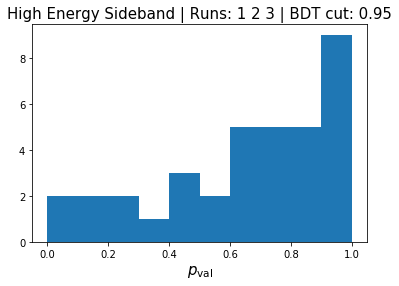

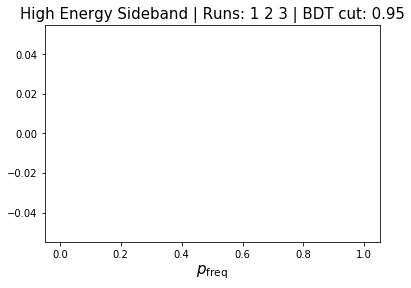

<Figure size 432x288 with 0 Axes>

In [41]:
if not finalPred:
    plt.hist(pvalsa,bins=10,range=(0,1))
    plt.xlabel(r'$p_{\rm ana}$',fontsize=15)
    plt.title(plotTitle,fontsize=15)
    plt.savefig('Plots/'+tag+'/SelectionPlots/'+cutmodedir+'/'+'pvalsa.png')         
    plt.show()
    pkl.dump(  plt.gcf(),  open('Plots/'+tag+'/SelectionPlots/'+cutmodedir+'/'+'pvalsa.pickle',  'wb')  )
    plt.clf()
    
    plt.hist(pvalsf,bins=10,range=(0,1))
    plt.xlabel(r'$p_{\rm freq}$',fontsize=15)
    plt.title(plotTitle,fontsize=15)
    plt.savefig('Plots/'+tag+'/SelectionPlots/'+cutmodedir+'/'+'pvalsf.png')         
    plt.show()
    pkl.dump(  plt.gcf(),  open('Plots/'+tag+'/SelectionPlots/'+cutmodedir+'/'+'pvalsf.pickle',  'wb')  )
    plt.clf()

In [ ]:
tsavedir = 'TextFiles/'+tag+'/'
try: os.mkdir(tsavedir)
except OSError as error: print(error)
tsavedir = 'TextFiles/'+tag+'/'+cutmodedir+'/'
try: os.mkdir(tsavedir)
except OSError as error: print(error)
for bdtmode in ['avgscore','fracweight','medianscore']:
    tsavedir = 'TextFiles/'+tag+'/'+cutmodedir+'/'+bdtmode+'/'
    try: os.mkdir(tsavedir)
    except OSError as error: print(error)
    for r in [1,2,3]:
        for filetag in df[r].keys():
            if not lowEpatch and 'lowE' in filetag: continue
            #if not 'data' in filetag: continue
            dfc = df[r][filetag].copy()
            SaveTextFile(dfc,r,filetag+'_fset%i'%fset,0.0,bdtmode,tsavedir)